In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [14]:
image_dir = Path('/content/drive/MyDrive/Colab Notebooks/age-image-file')

filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)

def extract_age(filepath):
    parent_directory = os.path.dirname(filepath)
    return os.path.split(parent_directory)[1]

ages = pd.Series(filepaths.map(extract_age), name='Age').astype(int)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True) #suffle data
print(images)


                                                Filepath  Age
0      /content/drive/MyDrive/Colab Notebooks/age-ima...   30
1      /content/drive/MyDrive/Colab Notebooks/age-ima...   38
2      /content/drive/MyDrive/Colab Notebooks/age-ima...   41
3      /content/drive/MyDrive/Colab Notebooks/age-ima...   39
4      /content/drive/MyDrive/Colab Notebooks/age-ima...   40
...                                                  ...  ...
26912  /content/drive/MyDrive/Colab Notebooks/age-ima...   28
26913  /content/drive/MyDrive/Colab Notebooks/age-ima...   37
26914  /content/drive/MyDrive/Colab Notebooks/age-ima...   42
26915  /content/drive/MyDrive/Colab Notebooks/age-ima...   30
26916  /content/drive/MyDrive/Colab Notebooks/age-ima...   20

[26917 rows x 2 columns]


Age: 8


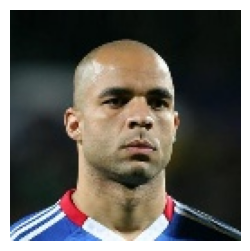

In [48]:
def visualize(image):
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 5
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

(array([0]), [Text(0, 0, '0')])

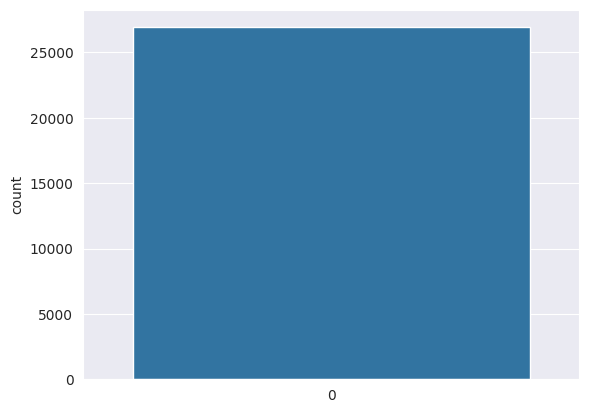

In [16]:
sns.countplot(images.Age)
plt.xticks()

In [17]:
images.Age = images.Age-20 # classify class 0 : 20 years , ... , class 31 : 50 years

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)

In [19]:
class ImageAgeDataset() :
  def __init__(self , images) :
    self.age = images.Age.values
    self.paths = images.Filepath.values

  def __len__(self) :
    return len(self.age)

  def __getitem__(self , item) :
    out = dict()
    path = self.paths[item]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image , dtype = float)
    out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255
    out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
    return out

In [20]:
train_dataset = ImageAgeDataset(train)
valid_dataset = ImageAgeDataset(valid)

In [21]:
class AlexNetwork(nn.Module):
    def __init__(self, n_classes):
        super(AlexNetwork, self).__init__()
        self.n_classes = n_classes
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 96,
            kernel_size = 11,
            stride = 4,
            padding = 50
        )
        self.pool_1 = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        )
        self.conv_2 = nn.Conv2d(
            in_channels = 96,
            out_channels = 256,
            kernel_size = 5,
            stride = 1,
            padding = 2
        )
        self.pool_2 = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        )
        self.conv_3 = nn.Conv2d(
            in_channels = 256,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.conv_4 = nn.Conv2d(
            in_channels = 384,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.conv_5 = nn.Conv2d(
            in_channels = 384,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.pool_3 = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        )
        self.nn = nn.Sequential(nn.Linear(in_features = 9216, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = self.n_classes),
                               )
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_3(x)
        x = x.view(-1,9216)
        x = self.nn(x)
        return x

In [22]:
#hparams
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 5
LR = 1e1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 8
)
#---------------------
model = AlexNetwork(31)
model.to(DEVICE)
#---------------------
loss_fn = nn.CrossEntropyLoss()
#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
#---------------------
from tqdm.notebook import tqdm
import numpy as np
def train_step(model , optimizer , dataloader):
  model.train()
  total_loss = 0
  for data in tqdm(dataloader):
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader):
  model.eval()
  total_loss = 0
  for data in tqdm(dataloader):
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y)
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model, optimizer, train_dataloader, valid_dataloader):
    train_losses = []
    valid_losses = []
    min_valid_loss = np.inf
    patience = 0

    for epoch in range(EPOCHS):
        train_loss = train_step(model, optimizer, train_dataloader)
        train_losses.append(train_loss)
        valid_loss = valid_step(model, valid_dataloader)
        valid_losses.append(valid_loss)
        print(f'EPOCH = {epoch}')
        print(f'train_loss = {train_loss}')
        print(f'valid_loss = {valid_loss}')

        if valid_loss > min_valid_loss:
            patience += 1
        else:
            min_valid_loss = valid_loss
            patience = 0

        if patience > MAX_WAIT:
            print(f'EARLY STOPPING AT EPOCH = {epoch}')
            break

    # Plotting the train loss and valid loss using seaborn
    epochs = range(len(train_losses))
    sns.set_style("darkgrid")
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss and Valid Loss')
    plt.legend()
    plt.show()
    return train_losses, valid_losses

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 5.309888875414897e+26
valid_loss = 1.4953631865053228e+26


  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 8.105686961379854e+25
valid_loss = 6.415111513991341e+25


  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 4.051777272848268e+25
valid_loss = 9.319122082234696e+25


  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 6.501278309126783e+25
valid_loss = 3.331315100861337e+25


  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 4.279841006558808e+25
valid_loss = 3.8349562517041774e+25


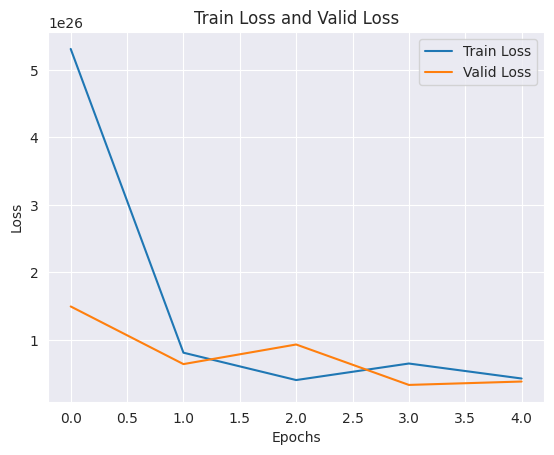

In [23]:
train_losses, valid_losses = main(
    model = model,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)